# import

In [85]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import subprocess
import warnings
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score , confusion_matrix, classification_report, plot_confusion_matrix, ConfusionMatrixDisplay
#################################################
#collab imports
import io
from google.colab import files

In [3]:
###################################### upload files to collab
train = files.upload()
df = pd.read_csv(io.BytesIO(train['train_final.csv']))

Saving train_final.csv to train_final.csv


In [ ]:
df = pd.read_csv('data/train_final.csv')

In [86]:
df.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,Sex_male,Embarked_Q,Embarked_S,Title_Master.,Title_Miss.,Title_Mr.,Title_Mrs.,Title_Rare,Title_Rev.
0,0,3,22.0,1,0,2.110213,1,0,1,0,0,1,0,0,0
1,1,1,38.0,1,0,4.280593,0,0,0,0,0,0,1,0,0
2,1,3,26.0,0,0,2.188856,0,0,1,0,1,0,0,0,0
3,1,1,35.0,1,0,3.990834,0,0,1,0,0,0,1,0,0
4,0,3,35.0,0,0,2.202765,1,0,1,0,0,1,0,0,0


# train test split

In [87]:
X = df.drop(['Survived'], axis=1)
y = df['Survived']

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

## Standard Scaler

In [90]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Applying Standard Scaler to Age and Fare both while it was not really necessary to apply this in Fare , that was not that much speaded after the previous log transformation
X_train[['Age','Fare']] = scaler.fit_transform(X_train[['Age','Fare']])
X_test[['Age','Fare']] = scaler.transform(X_test[['Age','Fare']])

# Making a One Time Call Function

In [7]:
####################################upload performance and csv files to collab

perfromance_csv = files.upload()
performance_ = pd.read_csv(io.BytesIO(perfromance_csv['performance_on_train_data.csv']))


training_csv = files.upload()   #overfitting csv
train_fitting = pd.read_csv(io.BytesIO(training_csv['performance_on_test_data.csv']))


Saving performance_on_train_data.csv to performance_on_train_data.csv


Saving performance_on_test_data.csv to performance_on_test_data.csv


This is a Classification Problem hence our goal is to maximize the accuracy of our model.


But Maximizing the only accuracy is not a good idea, We need to look for other metrics also like precision, recall, f1-score, ROC-AUC, etc.

In [ ]:
#performance_ = pd.DataFrame(columns=['Model','Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])
#train_fitting = pd.DataFrame(columns=['Model','Accuracy', 'Precision', 'Recall', 'F1', 'ROC_AUC'])

In [10]:
#performance_ = pd.read_csv('data/performance_on_train_data.csv')
#train_fitting = pd.read_csv('data/performance_on_test_data.csv')
#################################  Evaluate Model ###############################################
def evaluate_metrics( model, train=False, save=False, model_name=None,evaluate=True,visualize=False):


    '''

    Evaluate the model's performance
    Train: True if model is being evaluated on training data
    Save: True if model's results are meant to be saved
    model_name: Name of the model being evaluated

    '''

    if model_name is None:
        model_name = model.__class__.__name__

    if train:
        y_ = y_train
        x_ = X_train
    else:
        y_ = y_test
        x_ = X_test

    predictions = model.predict(x_)


    accuracy = accuracy_score(y_, predictions)
    precision = precision_score(y_, predictions)
    recall = recall_score(y_, predictions)
    f1 = f1_score(y_, predictions)
    roc_auc = roc_auc_score(y_, predictions)

    
    if save & evaluate:
        if train:
            train_fitting.loc[len(train_fitting)] = [model_name, accuracy, precision, recall, f1, roc_auc]
            print(train_fitting.iloc[len(train_fitting)-1])
        else:
            performance_.loc[len(performance_)] = [model_name, accuracy, precision, recall, f1, roc_auc]
            print(performance_.iloc[len(performance_)-1])
    elif evaluate:
        print(
            'accuracy :'+str(accuracy)+'\n'
            'precision :'+str(precision)+'\n'
            'recall :'+str(recall)+'\n'
            'f1 :'+str(f1)+'\n'
            'roc_auc :'+str(roc_auc)+'\n'
        )
    else:
        if train:
            train_fitting.loc[len(train_fitting)] = [model_name, accuracy, precision, recall, f1, roc_auc]
        else:
            performance_.loc[len(performance_)] = [model_name,accuracy, precision, recall, f1, roc_auc]


    if visualize:
        visualize_result(model)

####################################################################################################
####################################################################################################


################################  Visualize Results ################################################

def visualize_result(model):

    '''

    Visualize the results of the model
    cat: True if model is being visualized on categorical data
    model: Model to be visualized

    '''

    x_ = X_test
   
    

    predictions = model.predict(x_)

    cm = confusion_matrix(y_test, predictions)
    disp =ConfusionMatrixDisplay(cm).plot()
    disp.figure_.set_size_inches(10,7)

    print(classification_report(y_test, predictions))


####################################################################################################
####################################################################################################


########################################### Run Models ##############################################

def run_model(model, train=False, evaluate=True, save=False, model_name=None, visualize=False):

    '''

    Run the model
    train: True if model is being run on training data
    cat: True if model is being run on categorical data
    model: Model to be run

    For Saving the model, set save=True and evaluate=True

    '''
    # model is always going to fit on Training data only cat can vary
    x_ = X_train

    model.fit(x_, y_train)


    if evaluate:
        evaluate_metrics(model, train=train,  save=save, model_name=model_name)

    if visualize:
        visualize_result(model)
    


####################################################################################################
####################################################################################################


########################################### Grid Search ##############################################
def run_grid_search(model, param_grid,train=False, evaluate=True, save=False, model_name=None, visualize=False, **kwargs):

    '''

    Run the model
    train: True if model is being run on training data
    cat: True if model is being run on categorical data
    model: Model to be run

    '''
    warnings.filterwarnings('ignore')

   
    x_ = X_train

    grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', **kwargs)
    grid_search.fit(x_, y_train)

    print('\n')
    print("Best Parameter: ",grid_search.best_params_)
    print('\n')
    print("Best Score: ",grid_search.best_score_)

    if evaluate:
        evaluate_metrics(grid_search.best_estimator_, train=train,  save=save, model_name=model_name)

    if visualize:
        visualize_result(grid_search.best_estimator_)

    #send_notification()

    return grid_search
    

def save_performance(perform=performance_,training=train_fitting):
    perform.to_csv('data/performance_on_train_data.csv', index=False)
    training.to_csv('data/performance_on_test_data.csv', index=False)

#def send_notification(message='Task Completed'):
#    subprocess.run(['notify-send' ,message])

# Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

Model        Logistic Regression Initial
Accuracy                        0.826816
Precision                       0.794521
Recall                          0.783784
F1                              0.789116
ROC_AUC                         0.820463
Name: 0, dtype: object
              precision    recall  f1-score   support

           0       0.85      0.86      0.85       105
           1       0.79      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



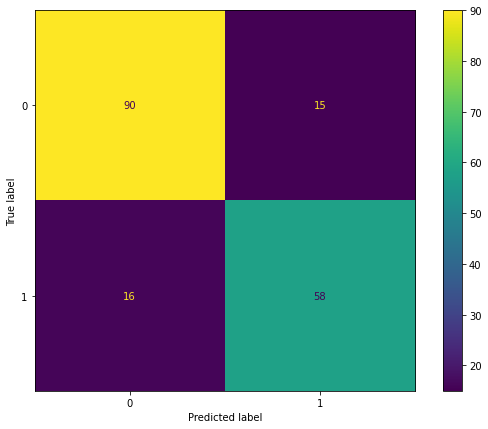

In [ ]:
lginitial = LogisticRegression(random_state=42)
run_model(lginitial, train=False,  evaluate=True, save=True, model_name='Logistic Regression Initial', visualize=True)

In [ ]:
evaluate_metrics(model=lginitial, save=True,train=True,evaluate=False,model_name="Logistic Regression Initial") # saving for training data

- let's tune the hyperparameters of our model

## Grid Search

In [ ]:
lginitial.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': 42,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

***

- Now Trying to change the parameters of Logistic Regression
1. C: Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.

2. penalty : {'l1', 'l2', 'elasticnet', 'none'}, default='l2'
    Specify the norm of the penalty:

    'none': no penalty is added;

    'l2': add a L2 penalty term and it is the default choice;

    'l1': add a L1 penalty term;

    'elasticnet': both L1 and L2 penalty terms are added.

3. l1_ratio : float, default=None
    
    The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting 
    
    l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using 
    
    penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.



4. solver : {'newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'}, default='lbfgs'
    Algorithm to use in the optimization problem.


5. class_weight : dict or 'balanced', default=None
    

In [ ]:
param_grid = {'C': [0.01, 0.1 ,1, 10, 100, 1000], 
            'penalty': ['l1', 'l2', 'elasticnet'],
            'l1_ratio': [0,0.1, 0.5, 0.9, 1.0],
            'solver':['saga','lbfgs'],
            'class_weight':['balanced', None]
}

In [ ]:
lggrid_1 = LogisticRegression(random_state=42, max_iter=10000)
grid_1 = run_grid_search(model = lggrid_1, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='Logistic Regression', visualize=False, n_jobs=-1)

/home/shailja/.virtualenv/mlearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/shailja/.virtualenv/mlearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/shailja/.virtualenv/mlearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/shailja/.virtualenv/mlearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/home/shailja/.virtualenv/mlearning/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:1106: UserWarning: l1_ratio parameter is only



Best Parameter:  {'C': 1, 'class_weight': None, 'l1_ratio': 0, 'penalty': 'l1', 'solver': 'saga'}


Best Score:  0.832837584950261
accuracy :0.8100558659217877
precision :0.7777777777777778
recall :0.7567567567567568
f1 :0.7671232876712328
roc_auc :0.8021879021879021



- As this Result is not better than normal Logistic Regression, we will not be changing the parameters.
- Saving The score and moving towrds next model

Model        Logistic Regression Final
Accuracy                      0.810056
Precision                     0.777778
Recall                        0.756757
F1                            0.767123
ROC_AUC                       0.802188
Name: 1, dtype: object
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



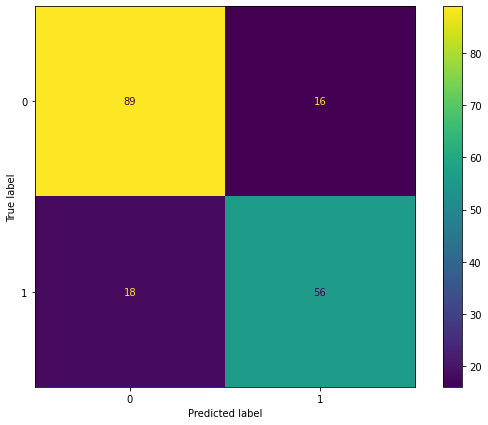

In [ ]:
evaluate_metrics(grid_1.best_estimator_, save=True, model_name='Logistic Regression Final',visualize=True)

In [ ]:
evaluate_metrics(model=grid_1.best_estimator_, save=True,train=True,evaluate=False,model_name="Logistic Regression Final") # saving for training data

In [ ]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188


In [ ]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341


In [ ]:
save_performance(perform=performance_, training=train_fitting)

# KNN 

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

Model        KNN Initial
Accuracy        0.832402
Precision       0.805556
Recall          0.783784
F1              0.794521
ROC_AUC         0.825225
Name: 2, dtype: object
              precision    recall  f1-score   support

           0       0.85      0.87      0.86       105
           1       0.81      0.78      0.79        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



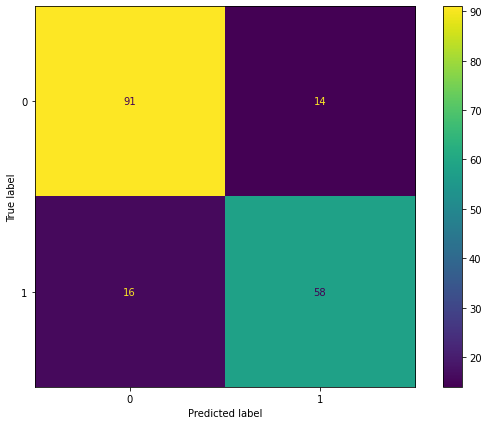

In [ ]:
knninitial = KNeighborsClassifier()
run_model(knninitial, train=False,  evaluate=True, save=True, model_name='KNN Initial', visualize=True)

In [ ]:
evaluate_metrics(model=knninitial, save=True,train=True,evaluate=False,model_name="KNN Initial") # saving for training data

- Let's tune the parameters

## Grid Search

In [ ]:
knninitial.get_params()

{'algorithm': 'auto',
 'leaf_size': 30,
 'metric': 'minkowski',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 5,
 'p': 2,
 'weights': 'uniform'}

- We will now find the best n_neighbors value for KNN using Elbow method

In [ ]:
def n_neighbors_value(n=50):
    accuracy = []
    for i in range(1,n):
        model = KNeighborsClassifier(n_neighbors=i)
        model.fit(X_train, y_train)
        accuracy.append(accuracy_score(y_test, model.predict(X_test)))
    return accuracy        

In [ ]:
acc = n_neighbors_value(30)

<AxesSubplot:>

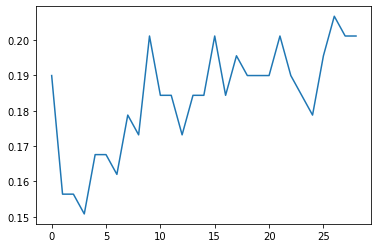

In [ ]:
sns.lineplot(x=range(len(acc)), y=1-np.array(acc))

- from the graph we can see that the elbow is at n_neighbors between 15 and 20.
- Taking n_neighbors in range 15-20

***

- Now we will try to change other parameters of KNN.

1. n_neighbors : Number of neighbors to use by default for kneighbors queries.

2. weights : {'uniform', 'distance'} or array-like of shape (n_neighbors,), default='uniform'
    Weight function used in prediction. If 'uniform', the weights are uniform; if 'distance', the weights 
    are inversely proportional to the number of observations.

3. metric : string or callable, default='minkowski'
    Metric to use for distance computation. If metric is a string or callable, it must be one of the 
    values allowed by metrics.pairwise.pairwise_distances for its metric parameter.

4. p : int, default=2
    Parameter for the Minkowski metric from sklearn.metrics.pairwise.pairwise_distances. When p = 1, 
    this is equivalent to using manhattan_distance (l1), and euclidean_distance (l2) for p = 2. For arbitrary 
    p, minkowski_distance (l_p) is used.


5. leaf_size : int, default=30
    Leaf size passed to BallTree or KDTree. This can affect the speed of the construction and query, as well 
    as the memory required to store the tree. The optimal value depends on the nature of the problem.
    

In [ ]:
knn_grid = KNeighborsClassifier()

param_grid = {'n_neighbors': [5,10,15,17,20],   # changing between 15-20
            'weights': ['uniform', 'distance'],
            'p': [1,2,3],
            'leaf_size': [10,20,30,40,50],
}

In [ ]:
grid_1 = run_grid_search(model = knn_grid, param_grid=param_grid, train=False, evaluate=True, save=False, model_name='KNN', visualize=False, n_jobs=4)



Best Parameter:  {'leaf_size': 10, 'n_neighbors': 20, 'p': 1, 'weights': 'uniform'}


Best Score:  0.8342460356544864
accuracy :0.7932960893854749
precision :0.7936507936507936
recall :0.6756756756756757
f1 :0.72992700729927
roc_auc :0.7759330759330759



- It was better with default parameters

              precision    recall  f1-score   support

           0       0.79      0.88      0.83       105
           1       0.79      0.68      0.73        74

    accuracy                           0.79       179
   macro avg       0.79      0.78      0.78       179
weighted avg       0.79      0.79      0.79       179



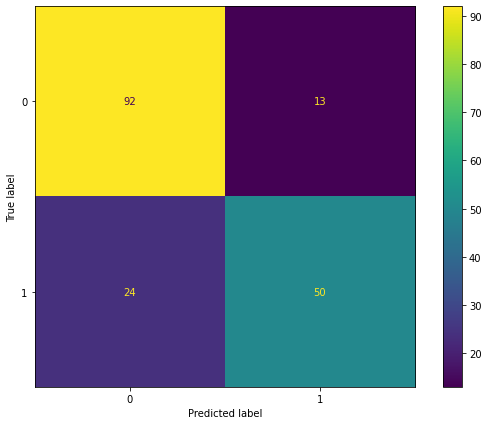

In [ ]:
evaluate_metrics(grid_1.best_estimator_, save=True, model_name='KNN Final',visualize=True,evaluate=False)

In [ ]:
evaluate_metrics(model=grid_1.best_estimator_, save=True,train=True,evaluate=False,model_name="KNN Final") # saving for training data

In [ ]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933


In [ ]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752


In [ ]:
save_performance(performance_, train_fitting)

# SVC

In [ ]:
from sklearn.svm import SVC

Model        SVC Initial
Accuracy        0.815642
Precision       0.788732
Recall          0.756757
F1              0.772414
ROC_AUC          0.80695
Name: 7, dtype: object
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



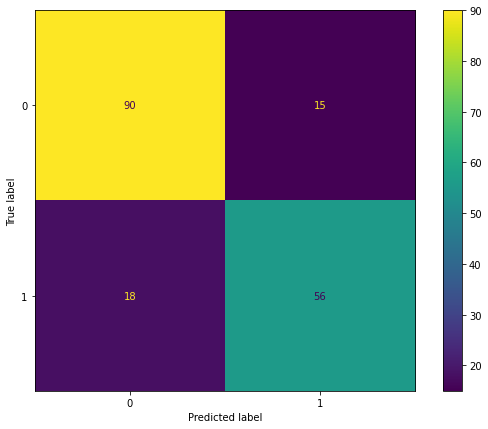

In [ ]:
svcinitial = SVC(random_state=42)
run_model(svcinitial, train=False,  evaluate=True, save=True, model_name='SVC Initial', visualize=True)

In [ ]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933
4,SVC Initial,0.815642,0.788732,0.756757,0.772414,0.806950


In [ ]:
evaluate_metrics(model=svcinitial, save=True,train=True,evaluate=False,model_name="SVC Initial") # saving for training data

In [ ]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752
4,SVC Initial,0.838483,0.820084,0.731343,0.773176,0.817248


## Grid Search

In [ ]:
svcinitial.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 42,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

***

- Now we will try to change other parameters of SVC.

1. C : float, default=1.0
    Penalty parameter C of the error term.

2. kernel : string, default='rbf'
    Specifies the kernel type to be used in the algorithm. It must be one of 'linear', 'poly', 'rbf', 'sigmoid', # As this is a classification Problem we only is rbl and sigmoid as kernel

3. gamma : float, default=0.0
    Kernel coefficient for 'rbf' and 'poly' kernels. Ignored by other kernels.


4. coef0 : float, default=0.0
    Independent term in kernel function. It is only significant in 'poly' and 'sigmoid'.


5. class_weight : dict or 'balanced', default=None
    Set the parameter C of class i to class_weight[i]*C for SVC. If not given, all classes are supposed to have 
    weight one. The “balanced” mode uses the values of y to automatically adjust weights inversely proportional to 
    class frequencies in the input data as n_samples / (n_classes * np.bincount(y))


In [ ]:
svc_grid = SVC(random_state=42)

In [ ]:
param_grid = {'C': [0.01, 0.1 ,1, 10, 100, 1000],
            'kernel': ['rbf', 'sigmoid'],
            'gamma': [0.001, 0.01, 0.1, 1, 10, 'scale','auto'],
            'class_weight':['balanced', None],
            'coef0':[0.0, 0.1, 1, 10, 100]
}

In [ ]:
grid_1 = run_grid_search(model = svc_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='SVC', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 840 candidates, totalling 4200 fits


Best Parameter:  {'C': 1000, 'class_weight': None, 'coef0': 0.0, 'gamma': 0.001, 'kernel': 'rbf'}


Best Score:  0.8314094356347879
accuracy :0.8212290502793296
precision :0.8
recall :0.7567567567567568
f1 :0.7777777777777778
roc_auc :0.8117117117117117



- let's narrow down the tuning

In [ ]:
param_grid = {'C': [800,1000,1200],
            'kernel': ['rbf'],
            'gamma': [0.001, 0.002],
            'class_weight':[None],
            'coef0':[0.0, 0.001,0.003]
}

In [ ]:
grid_2 = run_grid_search(model = svc_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='SVC', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best Parameter:  {'C': 1000, 'class_weight': None, 'coef0': 0.0, 'gamma': 0.001, 'kernel': 'rbf'}


Best Score:  0.8314094356347879
accuracy :0.8212290502793296
precision :0.8
recall :0.7567567567567568
f1 :0.7777777777777778
roc_auc :0.8117117117117117



- No further improvement, hence saving it

Model        SVC Final
Accuracy      0.821229
Precision          0.8
Recall        0.756757
F1            0.777778
ROC_AUC       0.811712
Name: 5, dtype: object
              precision    recall  f1-score   support

           0       0.83      0.87      0.85       105
           1       0.80      0.76      0.78        74

    accuracy                           0.82       179
   macro avg       0.82      0.81      0.81       179
weighted avg       0.82      0.82      0.82       179



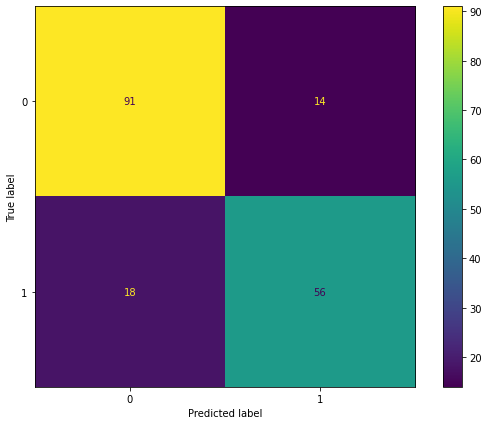

In [ ]:
evaluate_metrics(grid_2.best_estimator_,save=True,model_name="SVC Final",visualize=True)

In [ ]:
evaluate_metrics(model=grid_2.best_estimator_, save=True,train=True,evaluate=False,model_name="SVC Final") # saving for training data

In [ ]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933
4,SVC Initial,0.815642,0.788732,0.756757,0.772414,0.806950
5,SVC Final,0.821229,0.800000,0.756757,0.777778,0.811712


In [ ]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752
4,SVC Initial,0.838483,0.820084,0.731343,0.773176,0.817248
5,SVC Final,0.834270,0.809917,0.731343,0.768627,0.813870


In [ ]:
save_performance(performance_,training=train_fitting)

# Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
dtinitial = DecisionTreeClassifier(random_state=42)

Model        Decision Tree Initial
Accuracy                  0.782123
Precision                 0.733333
Recall                    0.743243
F1                        0.738255
ROC_AUC                   0.776384
Name: 6, dtype: object
              precision    recall  f1-score   support

           0       0.82      0.81      0.81       105
           1       0.73      0.74      0.74        74

    accuracy                           0.78       179
   macro avg       0.78      0.78      0.78       179
weighted avg       0.78      0.78      0.78       179



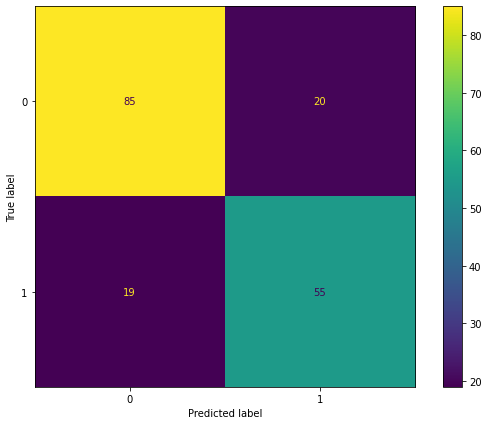

In [ ]:
run_model (dtinitial, train=False,  evaluate=True, save=True, model_name='Decision Tree Initial', visualize=True)

In [ ]:
evaluate_metrics(model=dtinitial, save=True,train=True,evaluate=False,model_name="Decision Tree Initial") # saving for training data

- Here dtinitial model giving poor result let's check it's performance in training data

In [ ]:
evaluate_metrics(dtinitial,train=True)

accuracy :0.9817415730337079
precision :0.9961089494163424
recall :0.9552238805970149
f1 :0.9752380952380951
roc_auc :0.9764858141723813



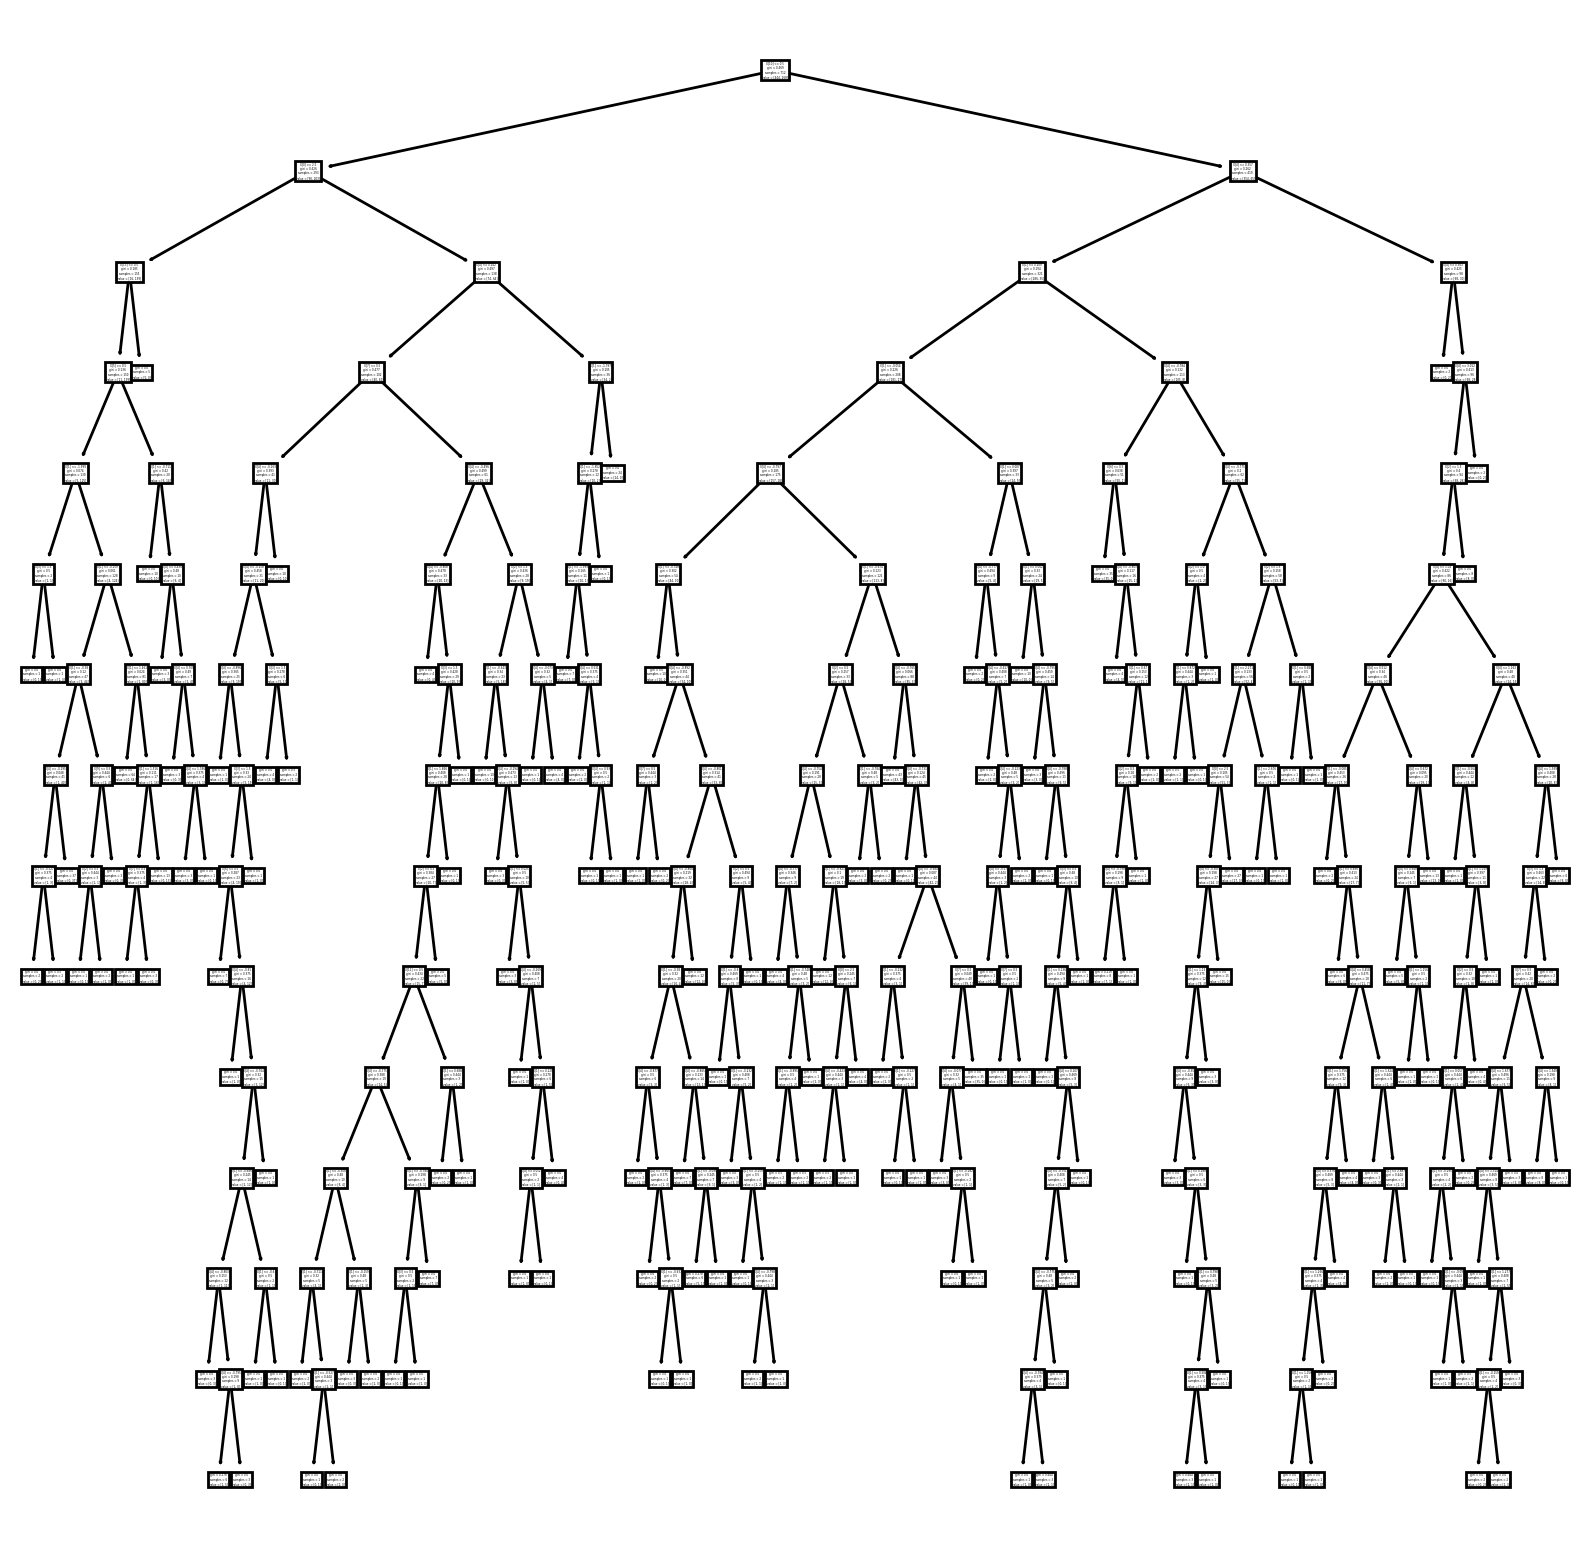

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(10,10),dpi=200)
plot_tree(dtinitial);

- from above it is clear that the model dtinitial is overfitting the training data as it is giving 98% accuracy to training data while perform relatively poor on test data
- Hence let's do grid search for finding the best hyperparameters

***

- Now we will change the parameters so that it will not overfit the training data and follow the general trend

1. max_depth : int or None, default=None
    The maximum depth of the tree. 

2. min_samples_split : int, default=2
    The minimum number of samples required to split an internal node.

3. min_samples_leaf : int, default=1
    The minimum number of samples required to be at a leaf node.


4. ccp_alpha : non-negative float, default=0.0
    Complexity parameter used in RBF and polynomial kernels.


5. class_weight : dict or 'balanced', default=None
    Weights associated with classes in the form {class_label: weight}. 

6. criterion : string, default='gini'
    The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “entropy” 
    for the information gain.


## Grid Search

In [ ]:
dt_grid = DecisionTreeClassifier(random_state=42)

In [ ]:
param_grid_1 = {'max_depth': [3,7,15],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [1,8,16],
            'ccp_alpha': [0.0, 0.1, 0.5, 1.0],
            'class_weight':['balanced', None],
            'criterion': ['gini', 'entropy']
}

In [ ]:
grid1 = run_grid_search(model = dt_grid, param_grid=param_grid_1, train=False,  evaluate=True, save=False, model_name='Decision Tree', visualize=False, n_jobs=6,verbose=1)

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


Best Parameter:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'min_samples_leaf': 1, 'min_samples_split': 10}


Best Score:  0.821619225844578
accuracy :0.8379888268156425
precision :0.8461538461538461
recall :0.7432432432432432
f1 :0.7913669064748202
roc_auc :0.824002574002574



- Narrow down the search

In [ ]:
param_grid1 = {'max_depth': [6,7,8],
            'min_samples_split': [10,11],
            'min_samples_leaf': [1,2,3],
            'ccp_alpha': [0.0],
            'class_weight':[ None],
            'criterion': ['gini']
}

In [ ]:
grid2 = run_grid_search(model = dt_grid, param_grid=param_grid1, train=False,  evaluate=True, save=False, model_name='Decision Tree', visualize=False, n_jobs=6,verbose=1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best Parameter:  {'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 10}


Best Score:  0.8300502314586822
accuracy :0.8324022346368715
precision :0.8548387096774194
recall :0.7162162162162162
f1 :0.7794117647058824
roc_auc :0.8152509652509652



- No more improvement, while decreasing , hence saving the grid-1

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       105
           1       0.85      0.74      0.79        74

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



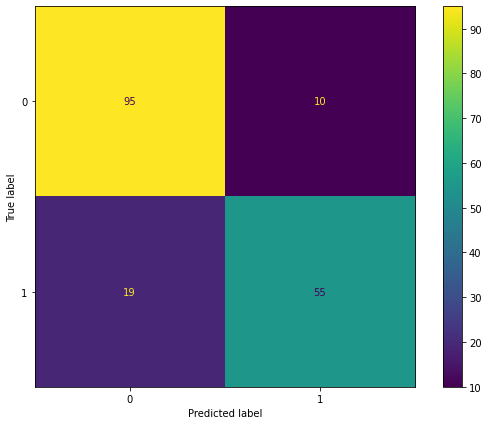

In [ ]:
evaluate_metrics(grid1.best_estimator_,visualize=True,save=True,evaluate=False,model_name='Decision Tree Final')

In [ ]:
evaluate_metrics(model=grid2.best_estimator_, save=True,train=True,evaluate=False,model_name="Decision Tree Final") # saving for training data

In [ ]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933
4,SVC Initial,0.815642,0.788732,0.756757,0.772414,0.806950
5,SVC Final,0.821229,0.800000,0.756757,0.777778,0.811712
6,Decision Tree Initial,0.782123,0.733333,0.743243,0.738255,0.776384
7,Decision Tree Final,0.837989,0.846154,0.743243,0.791367,0.824003


In [ ]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752
4,SVC Initial,0.838483,0.820084,0.731343,0.773176,0.817248
5,SVC Final,0.834270,0.809917,0.731343,0.768627,0.813870
6,Decision Tree Initial,0.981742,0.996109,0.955224,0.975238,0.976486
7,Decision Tree Final,0.870787,0.915094,0.723881,0.808333,0.841670


In [ ]:
save_performance(performance_,train_fitting)

# Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

Model        Random Forest Initial
Accuracy                  0.832402
Precision                 0.782051
Recall                    0.824324
F1                        0.802632
ROC_AUC                    0.83121
Name: 8, dtype: object
              precision    recall  f1-score   support

           0       0.87      0.84      0.85       105
           1       0.78      0.82      0.80        74

    accuracy                           0.83       179
   macro avg       0.83      0.83      0.83       179
weighted avg       0.83      0.83      0.83       179



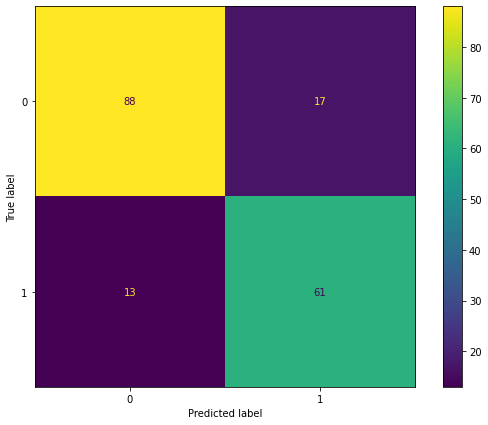

In [ ]:
rfcinitial = RandomForestClassifier(random_state=42)
run_model (rfcinitial, train=False,  evaluate=True, save=True, model_name='Random Forest Initial', visualize=True)

In [ ]:
evaluate_metrics(model=rfcinitial, save=True,train=True,evaluate=False,model_name="Random Forest Initial") # saving for training data

- let's perform grid search to get more accuracy

In [ ]:
rfcinitial.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'sqrt',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

***

- let's tune the parameters for better result

1. bootstrap : boolean, default=True
    Whether bootstrap samples are used when building trees.

2. n_estimators : int, default=10
    The number of trees in the forest.

3. max_features : int, float, string or None, default=None
    The number of features to consider when looking for the best split:
    
4. Rest of the parameters are same as Decision Tree

## Grid Search

In [ ]:
rfc_grid = RandomForestClassifier(random_state=42)

In [ ]:
def find_n(n):
    accuracy = []
    for i in range(20,n,10):
        rfc = RandomForestClassifier(random_state=42,n_estimators=i)
        rfc.fit(X_train,y_train)
        pred = rfc.predict(X_test)
        accuracy.append(accuracy_score(y_test,pred))
    return accuracy

In [ ]:
acc =find_n(200)

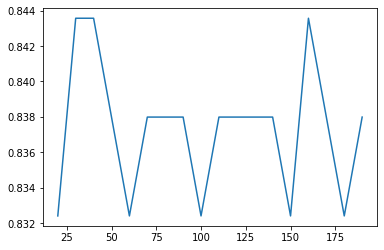

In [ ]:
plt.plot(range(20,200,10), acc)

- n_estimators is okay between 25-50

In [ ]:
param_grid = {'n_estimators': [25,30,40,45],
            'bootstrap': [True],
            'max_features': [ 'sqrt', 'log2',None],
            'max_depth': [3,7,15,None],
            'min_samples_split': [2,5,10],
            'min_samples_leaf': [1,8,16],
            'ccp_alpha': [0.0, 0.1, 0.5, 1.0],
            'class_weight':['balanced', None],
            'criterion': ['gini', 'entropy']
}


In [ ]:
grid_1 = run_grid_search(model = rfc_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='Random Forest', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 6912 candidates, totalling 34560 fits


Best Parameter:  {'bootstrap': True, 'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 7, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 30}


Best Score:  0.8384713877671626
accuracy :0.8212290502793296
precision :0.8181818181818182
recall :0.7297297297297297
f1 :0.7714285714285715
roc_auc :0.8077220077220078



- Narrowing down the tunning

In [ ]:
param_grid_2 = {'n_estimators': [65,70,75],
            'max_features': [None],
            'max_depth': [13,14,15],
            'min_samples_split': [9,10,11],
            'min_samples_leaf': [1,2,3],
            'ccp_alpha': [0.0,0.001,0.01],
            'class_weight':[ None],
            'criterion': ['gini']
}

In [ ]:
grid_2 = run_grid_search(model = rfc_grid, param_grid=param_grid_2, train=False,  evaluate=True, save=False, model_name='Random Forest', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 243 candidates, totalling 1215 fits


Best Parameter:  {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 13, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 70}


Best Score:  0.8272037821333598
accuracy :0.8379888268156425
precision :0.8260869565217391
recall :0.7702702702702703
f1 :0.7972027972027972
roc_auc :0.8279922779922779



- let's try to get more improvement as it's giving us better result than previous one, hence narrow down the search

In [ ]:
param_grid_3 = {'n_estimators': [68,70,72],
            'max_features': [None],
            'max_depth': [12,13,14],
            'min_samples_split': [10],
            'min_samples_leaf': [2],
            'ccp_alpha': [0.001,0.003],
            'class_weight':[ None],
            'criterion': ['gini']
}

In [ ]:
grid_2 = run_grid_search(model = rfc_grid, param_grid=param_grid_3, train=False,  evaluate=True, save=False, model_name='Random Forest', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


Best Parameter:  {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 70}


Best Score:  0.8272037821333598
accuracy :0.8435754189944135
precision :0.8382352941176471
recall :0.7702702702702703
f1 :0.8028169014084507
roc_auc :0.8327541827541827



- let's try to do more fine tuning

In [ ]:
param_grid_4 = {'n_estimators': [69,70,71],
            'max_features': [None],
            'max_depth': [12],
            'min_samples_split': [10],
            'min_samples_leaf': [2],
            'ccp_alpha': [0.001,0.0008],
            'class_weight':[ None],
            'criterion': ['gini']
}

In [ ]:
grid_3 = run_grid_search(model = rfc_grid, param_grid=param_grid_4, train=False,  evaluate=True, save=False, model_name='Random Forest', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


Best Parameter:  {'ccp_alpha': 0.001, 'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'max_features': None, 'min_samples_leaf': 2, 'min_samples_split': 10, 'n_estimators': 70}


Best Score:  0.8272037821333598
accuracy :0.8435754189944135
precision :0.8382352941176471
recall :0.7702702702702703
f1 :0.8028169014084507
roc_auc :0.8327541827541827



- no more improvemnt, hence saving the result

              precision    recall  f1-score   support

           0       0.85      0.90      0.87       105
           1       0.84      0.77      0.80        74

    accuracy                           0.84       179
   macro avg       0.84      0.83      0.84       179
weighted avg       0.84      0.84      0.84       179



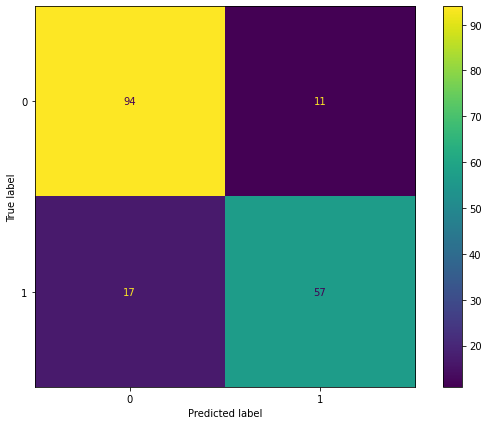

In [ ]:
evaluate_metrics(model=grid_3.best_estimator_,save=True,evaluate=False,visualize=True,model_name="Random Forest Final")

In [ ]:
evaluate_metrics(model=grid_2.best_estimator_, save=True,train=True,evaluate=False,model_name="Random Forest Final") # saving for training data

In [ ]:
save_performance(perform=performance_,training=train_fitting)

# AdaBoost 

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

In [ ]:
adainitial = AdaBoostClassifier(random_state=42)

Model        AdaBoost Initial
Accuracy             0.793296
Precision             0.74026
Recall                0.77027
F1                   0.754967
ROC_AUC              0.789897
Name: 10, dtype: object
              precision    recall  f1-score   support

           0       0.83      0.81      0.82       105
           1       0.74      0.77      0.75        74

    accuracy                           0.79       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.79      0.79      0.79       179



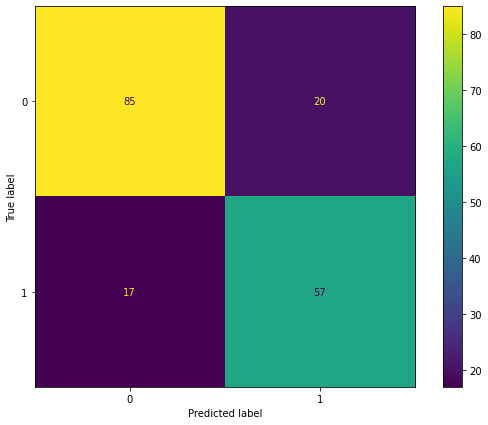

In [ ]:
run_model(adainitial, train=False,  evaluate=True, save=True, model_name='AdaBoost Initial', visualize=True)

In [ ]:
evaluate_metrics(model=adainitial, save=True,train=True,evaluate=False,model_name="AdaBoost Initial") # saving for training data

- let's try to tune the hyperparameters

## Grid Search

In [ ]:
adainitial.get_params()

{'algorithm': 'SAMME.R',
 'base_estimator': None,
 'learning_rate': 1.0,
 'n_estimators': 50,
 'random_state': 42}

***

- Tune the parameters for better result

1. n_estimators : int, default=50
    The number of boosting stages to perform.

2. learning_rate : float, default=1.0
    The learning rate shrinks the contribution of each tree by `learning_rate`.
    There is a trade-off between learning_rate and n_estimators.

3. algorithm : {'SAMME', 'SAMME.R'}, default='SAMME.R'
    If 'SAMME.R', then use the SAMME.R real boosting algorithm.
    Otherwise, use the SAMME algorithm.


In [ ]:
adb_grid = AdaBoostClassifier(random_state=42)

In [ ]:
param_grid = {'n_estimators': [30,50,70,100],
            'learning_rate': [0.001,0.01,0.1,0.5,1.0],
            'algorithm': ['SAMME', 'SAMME.R'], 
}

In [ ]:
grid_1 = run_grid_search(model = adb_grid, param_grid=param_grid, train=False, evaluate=True, save=False, model_name='AdaBoost', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


Best Parameter:  {'algorithm': 'SAMME.R', 'learning_rate': 0.1, 'n_estimators': 100}


Best Score:  0.8243967300305328
accuracy :0.8100558659217877
precision :0.7777777777777778
recall :0.7567567567567568
f1 :0.7671232876712328
roc_auc :0.8021879021879021



- let's narrow down the search

In [ ]:
param_grid = {'n_estimators': [85,100,150],
            'learning_rate': [0.09,0.1,0.2],
            'algorithm': [ 'SAMME.R'], 
}

In [ ]:
grid_2 = run_grid_search(model = adb_grid, param_grid=param_grid, train=False, evaluate=True, save=False, model_name='AdaBoost', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


Best Parameter:  {'algorithm': 'SAMME.R', 'learning_rate': 0.09, 'n_estimators': 85}


Best Score:  0.8243967300305328
accuracy :0.8100558659217877
precision :0.7777777777777778
recall :0.7567567567567568
f1 :0.7671232876712328
roc_auc :0.8021879021879021



- no more imrovement , hence saving the result

              precision    recall  f1-score   support

           0       0.83      0.85      0.84       105
           1       0.78      0.76      0.77        74

    accuracy                           0.81       179
   macro avg       0.80      0.80      0.80       179
weighted avg       0.81      0.81      0.81       179



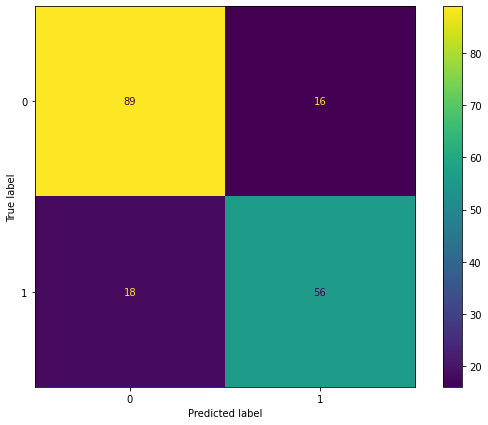

In [ ]:
evaluate_metrics(model=grid_2.best_estimator_,save=True,evaluate=False,visualize=True,model_name="AdaBoost Final")

In [ ]:
evaluate_metrics(model=grid_2.best_estimator_,save=True,train=True,evaluate=False,model_name="AdaBoost Final") # saving for training data

In [ ]:
save_performance(perform=performance_,training=train_fitting)

In [ ]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933
4,SVC Initial,0.815642,0.788732,0.756757,0.772414,0.806950
5,SVC Final,0.821229,0.800000,0.756757,0.777778,0.811712
6,Decision Tree Initial,0.782123,0.733333,0.743243,0.738255,0.776384
7,Decision Tree Final,0.837989,0.846154,0.743243,0.791367,0.824003
8,Random Forest Initial,0.832402,0.782051,0.824324,0.802632,0.831210
9,Random Forest Final,0.843575,0.838235,0.770270,0.802817,0.832754


In [ ]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752
4,SVC Initial,0.838483,0.820084,0.731343,0.773176,0.817248
5,SVC Final,0.834270,0.809917,0.731343,0.768627,0.813870
6,Decision Tree Initial,0.981742,0.996109,0.955224,0.975238,0.976486
7,Decision Tree Final,0.870787,0.915094,0.723881,0.808333,0.841670
8,Random Forest Initial,0.981742,0.984791,0.966418,0.975518,0.978704
9,Random Forest Final,0.903090,0.919831,0.813433,0.863366,0.885320


# Gradient Boosting

In [12]:
from sklearn.ensemble import GradientBoostingClassifier

In [13]:
gbinitial = GradientBoostingClassifier(random_state=42)

Model        Gradient Boosting Initial
Accuracy                      0.815642
Precision                     0.788732
Recall                        0.756757
F1                            0.772414
ROC_AUC                        0.80695
Name: 12, dtype: object
              precision    recall  f1-score   support

           0       0.83      0.86      0.85       105
           1       0.79      0.76      0.77        74

    accuracy                           0.82       179
   macro avg       0.81      0.81      0.81       179
weighted avg       0.81      0.82      0.82       179



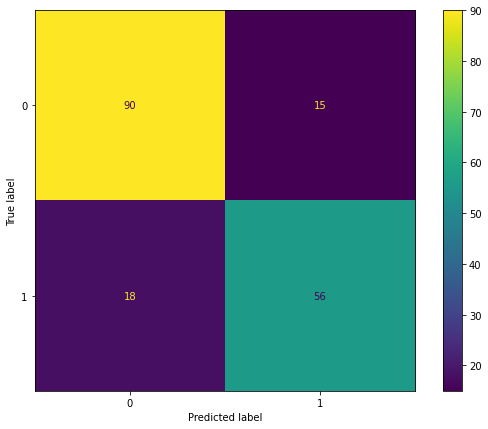

In [14]:
run_model(gbinitial, train=False,  evaluate=True, save=True, model_name='Gradient Boosting Initial', visualize=True)

In [15]:
evaluate_metrics(model=gbinitial, save=True,train=True,evaluate=False,model_name="Gradient Boosting Initial") # saving for training data

## Grid Search

In [16]:
gbinitial.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'friedman_mse',
 'init': None,
 'learning_rate': 0.1,
 'loss': 'deviance',
 'max_depth': 3,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_iter_no_change': None,
 'random_state': 42,
 'subsample': 1.0,
 'tol': 0.0001,
 'validation_fraction': 0.1,
 'verbose': 0,
 'warm_start': False}

***

- Here Num model is giving better result than cat model, hence tunning Num model's parameters to get better result

1. n_estimators : int, default=50
    The number of boosting stages to perform.

2. learning_rate : float, default=1.0
    The learning rate shrinks the contribution of each tree by `learning_rate`.
    There is a trade-off between learning_rate and n_estimators.

3. max_depth : int or None, default=3
    maximum depth of the individual regression estimators.

4. min_samples_split : int, default=2
    The minimum number of samples required to split an internal node.

5. min_samples_leaf : int, default=1
    The minimum number of samples required to be at a leaf node.

6. max_features : int, float, string or None, default=None
    The number of features to consider when looking for the best split:


In [17]:
gb_grid= GradientBoostingClassifier(random_state=42)

In [19]:
param_grid = {'n_estimators': [70,100,300],
            'learning_rate': [0.001,0.01,1.0],
            'max_depth': [7,15],
            'min_samples_split': [2,5],
            'min_samples_leaf': [1,8],
            'max_features': [ 'sqrt', 'log2',None],
            'max_leaf_nodes': [10,20,30],
            'criterion': ['friedman_mse', 'squared_error']
}

In [20]:
grid_1 = run_grid_search(model = gb_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='Gradient Boosting', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


Best Parameter:  {'criterion': 'squared_error', 'learning_rate': 0.01, 'max_depth': 7, 'max_features': 'sqrt', 'max_leaf_nodes': 30, 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 300}


Best Score:  0.8427065891854625
accuracy :0.8268156424581006
precision :0.8115942028985508
recall :0.7567567567567568
f1 :0.7832167832167832
roc_auc :0.8164736164736165



- let's narrow down the tunning

In [23]:
param_grid = {'n_estimators': [300,400],
            'learning_rate': [0.01,0.03],
            'max_depth': [7,9],
            'min_samples_split': [4,5,6],
            'min_samples_leaf': [1],
            'max_features': [ 'sqrt'],
            'max_leaf_nodes': [32,34],
            'criterion': ['squared_error']
}

In [24]:
grid_2 = run_grid_search(model = gb_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='Gradient Boosting', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


Best Parameter:  {'criterion': 'squared_error', 'learning_rate': 0.01, 'max_depth': 9, 'max_features': 'sqrt', 'max_leaf_nodes': 32, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 300}


Best Score:  0.8426967398798386
accuracy :0.8268156424581006
precision :0.8115942028985508
recall :0.7567567567567568
f1 :0.7832167832167832
roc_auc :0.8164736164736165



- This seems that we have achived a optimum value, hence saving the reult

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



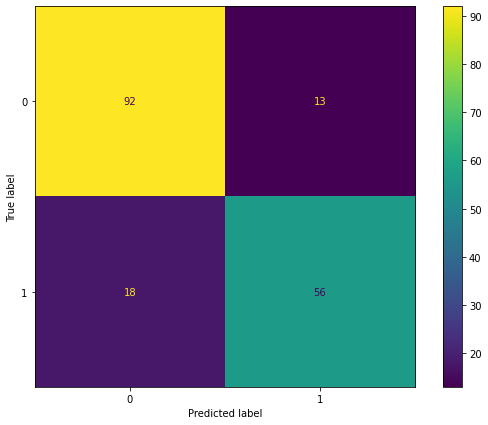

In [25]:
evaluate_metrics(model=grid_2.best_estimator_,save=True,evaluate=False,visualize=True,model_name="Gradient Boosting Final")

In [26]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933
4,SVC Initial,0.815642,0.788732,0.756757,0.772414,0.806950
5,SVC Final,0.821229,0.800000,0.756757,0.777778,0.811712
6,Decision Tree Initial,0.782123,0.733333,0.743243,0.738255,0.776384
7,Decision Tree Final,0.837989,0.846154,0.743243,0.791367,0.824003
8,Random Forest Initial,0.832402,0.782051,0.824324,0.802632,0.831210
9,Random Forest Final,0.843575,0.838235,0.770270,0.802817,0.832754


In [28]:
evaluate_metrics(model=grid_2.best_estimator_,save=True,train=True,evaluate=False,model_name="Gradient Boosting Final") # saving for training data

In [29]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752
4,SVC Initial,0.838483,0.820084,0.731343,0.773176,0.817248
5,SVC Final,0.834270,0.809917,0.731343,0.768627,0.813870
6,Decision Tree Initial,0.981742,0.996109,0.955224,0.975238,0.976486
7,Decision Tree Final,0.870787,0.915094,0.723881,0.808333,0.841670
8,Random Forest Initial,0.981742,0.984791,0.966418,0.975518,0.978704
9,Random Forest Final,0.903090,0.919831,0.813433,0.863366,0.885320


In [30]:
save_performance(performance_,train_fitting)

# GaussianNB

In [31]:
from sklearn.naive_bayes import GaussianNB

In [32]:
gauinitial = GaussianNB()

Model        GaussianNB Initial
Accuracy               0.430168
Precision              0.420455
Recall                      1.0
F1                        0.592
ROC_AUC                0.514286
Name: 14, dtype: object
              precision    recall  f1-score   support

           0       1.00      0.03      0.06       105
           1       0.42      1.00      0.59        74

    accuracy                           0.43       179
   macro avg       0.71      0.51      0.32       179
weighted avg       0.76      0.43      0.28       179



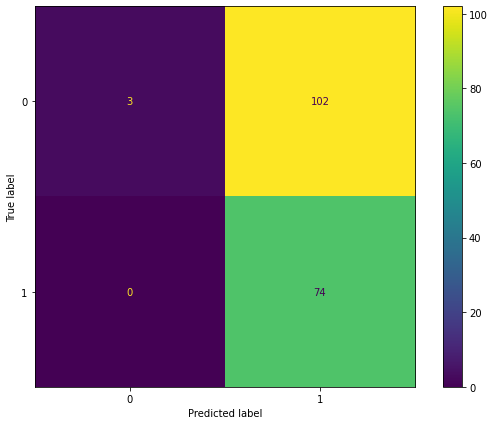

In [33]:
run_model(gauinitial, train=False,  evaluate=True, save=True, model_name='GaussianNB Initial', visualize=True)

In [34]:
evaluate_metrics(model=gauinitial, save=True,train=True,evaluate=False,model_name="GaussianNB Initial") # saving for training data

- This model is performing worst, hence moving towards the next one

In [35]:
save_performance(performance_,train_fitting)

# XGBClassifier

In [36]:
import xgboost as xgb

In [37]:
xgbinitial = xgb.XGBClassifier(random_state=42)

Model        XGB Classifier Initial
Accuracy                   0.798883
Precision                  0.771429
Recall                      0.72973
F1                             0.75
ROC_AUC                    0.788674
Name: 15, dtype: object
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       105
           1       0.77      0.73      0.75        74

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179



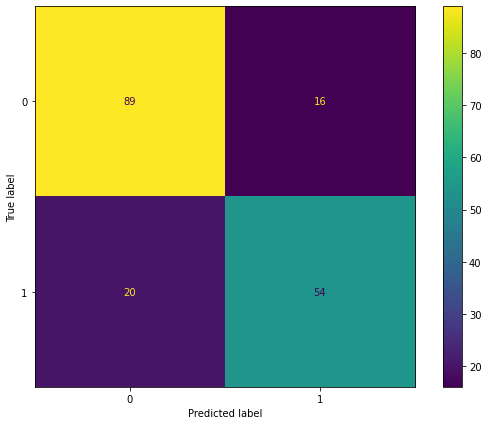

In [38]:
run_model(xgbinitial, train=False,  evaluate=True, save=True, model_name='XGB Classifier Initial', visualize=True)

In [39]:
evaluate_metrics(model=xgbinitial, save=True,train=True,evaluate=False,model_name="XGB Classifier Initial") # saving for training data

## Grid Search

In [40]:
xgbinitial.get_params()

{'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 1,
 'gamma': 0,
 'learning_rate': 0.1,
 'max_delta_step': 0,
 'max_depth': 3,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 100,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'binary:logistic',
 'random_state': 42,
 'reg_alpha': 0,
 'reg_lambda': 1,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 1,
 'verbosity': 1}

1. booster: {‘gbtree’, ‘gblinear’, ‘dart’}, default ‘gbtree’. The tree algorithm used.

2. min_child_weight: int, default 1. Minimum sum of instance weight(hessian) needed in a child.

3. max_delta_step: int, default 0. Maximum delta step we allow each tree’s weight estimation to be.

4. subsample: float, default 1.0. Subsample ratio of the training instances.

5. colsample_bytree: float, default 1.0. Subsample ratio of columns when constructing each tree.

6. colsample_bylevel: float, default 1.0. Subsample ratio of columns for each split, in each level.

7. gamma: float, default 0.0. Minimum loss reduction required to make a further partition on a leaf node of the tree.

8. reg_alpha: float, default 0.0. L1 regularization term on weights.

9. reg_lambda: float, default 1.0. L2 regularization term on weights.

In [43]:
xgb_grid = xgb.XGBClassifier(random_state=42)

In [44]:
param_grid = {'n_estimators': [70,100,300],
            'learning_rate': [0.001,0.01,1.0],
            'max_depth': [7,10,15],
            'min_child_weight': [1,2,3],
            'gammma': [0.1,0.5,1.0],
            'subsample': [0.5,0.8,1.0],
}

In [45]:
grid_1 = run_grid_search(model = xgb_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='XGBoost', visualize=False, n_jobs=-1,verbose=1)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


Best Parameter:  {'gammma': 0.1, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}


Best Score:  0.8286220821432091
accuracy :0.8268156424581006
precision :0.8115942028985508
recall :0.7567567567567568
f1 :0.7832167832167832
roc_auc :0.8164736164736165



- let's narrow down the parameters

In [47]:
param_grid = {'n_estimators': [300,400],
            'learning_rate': [0.008,0.01,0.03],
            'max_depth': [6,7,8],
            'min_child_weight': [2],
            'gammma': [0.08,0.1,0.2],
            'subsample': [0.9,1.0],
}

In [48]:
grid_2 = run_grid_search(model = xgb_grid, param_grid=param_grid, train=False,  evaluate=True, save=False, model_name='XGBoost', visualize=False, n_jobs=-1,verbose=3)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


Best Parameter:  {'gammma': 0.08, 'learning_rate': 0.01, 'max_depth': 7, 'min_child_weight': 2, 'n_estimators': 300, 'subsample': 1.0}


Best Score:  0.8286220821432091
accuracy :0.8268156424581006
precision :0.8115942028985508
recall :0.7567567567567568
f1 :0.7832167832167832
roc_auc :0.8164736164736165



- As now there is no further improvement in the result, hence saving it

              precision    recall  f1-score   support

           0       0.84      0.88      0.86       105
           1       0.81      0.76      0.78        74

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



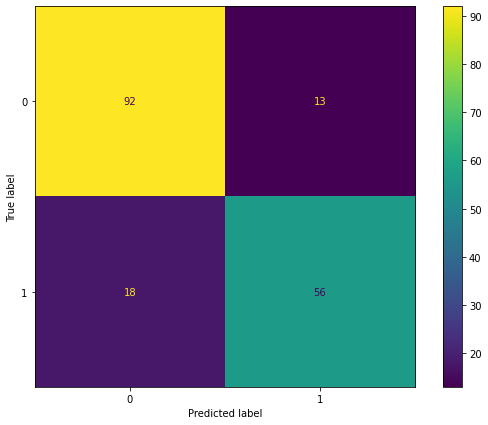

In [49]:
evaluate_metrics(model=grid_2.best_estimator_,save=True,evaluate=False,visualize=True,model_name="XGB Classifier Final")

In [50]:
performance_

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.826816,0.794521,0.783784,0.789116,0.820463
1,Logistic Regression Final,0.810056,0.777778,0.756757,0.767123,0.802188
2,KNN Initial,0.832402,0.805556,0.783784,0.794521,0.825225
3,KNN Final,0.793296,0.793651,0.675676,0.729927,0.775933
4,SVC Initial,0.815642,0.788732,0.756757,0.772414,0.806950
5,SVC Final,0.821229,0.800000,0.756757,0.777778,0.811712
6,Decision Tree Initial,0.782123,0.733333,0.743243,0.738255,0.776384
7,Decision Tree Final,0.837989,0.846154,0.743243,0.791367,0.824003
8,Random Forest Initial,0.832402,0.782051,0.824324,0.802632,0.831210
9,Random Forest Final,0.843575,0.838235,0.770270,0.802817,0.832754


In [51]:
evaluate_metrics(model=grid_2.best_estimator_,save=True,train=True,evaluate=False,model_name="XGB Classifier Final") # saving for training data

In [52]:
train_fitting

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
0,Logistic Regression Initial,0.839888,0.805556,0.757463,0.780769,0.823551
1,Logistic Regression Final,0.837079,0.808943,0.742537,0.774319,0.818341
2,KNN Initial,0.859551,0.855932,0.753731,0.801587,0.838577
3,KNN Final,0.842697,0.867925,0.686567,0.766667,0.811752
4,SVC Initial,0.838483,0.820084,0.731343,0.773176,0.817248
5,SVC Final,0.834270,0.809917,0.731343,0.768627,0.813870
6,Decision Tree Initial,0.981742,0.996109,0.955224,0.975238,0.976486
7,Decision Tree Final,0.870787,0.915094,0.723881,0.808333,0.841670
8,Random Forest Initial,0.981742,0.984791,0.966418,0.975518,0.978704
9,Random Forest Final,0.903090,0.919831,0.813433,0.863366,0.885320


In [53]:
save_performance(performance_,train_fitting)

# Final Visualization

- Now we will see which model is performing best by visualising different metrics

- deleting GaussianNB Initial as it's performance is worst

In [54]:
performance_[performance_['Model']  == 'GaussianNB Initial']

,Model,Accuracy,Precision,Recall,F1,ROC_AUC
14,GaussianNB Initial,0.430168,0.420455,1.0,0.592,0.514286


In [55]:
performance_.drop(performance_[performance_['Model']  == 'GaussianNB Initial'].index , inplace=True)
train_fitting.drop(train_fitting[train_fitting['Model']  == 'GaussianNB Initial'].index , inplace=True)

In [56]:
def plot_metrics(col):
  plt.figure(figsize=(10,8))
  x_per = performance_['Model']
  x_tra = train_fitting['Model']
  plt.plot(x_per, performance_[col],'b',label='Testing Data',marker='o')
  plt.plot(x_tra, train_fitting[col],'r',label='Training Data',marker='o')
  plt.legend()
  plt.xticks(rotation=90)
  plt.title(col)

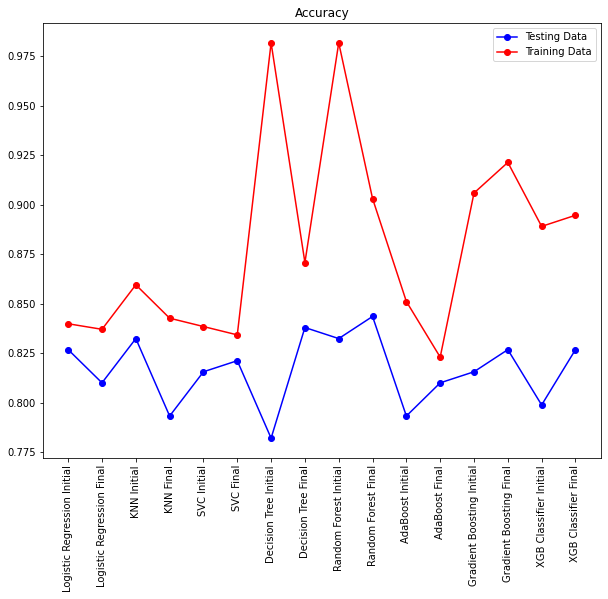

In [57]:
plot_metrics('Accuracy')

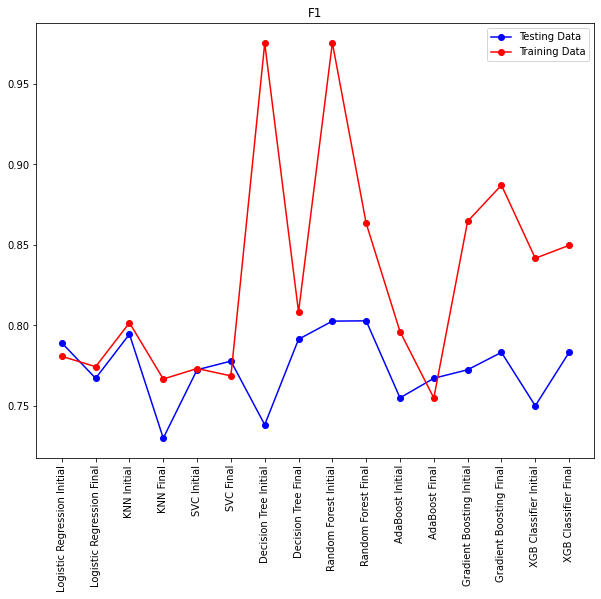

In [58]:
plot_metrics("F1")

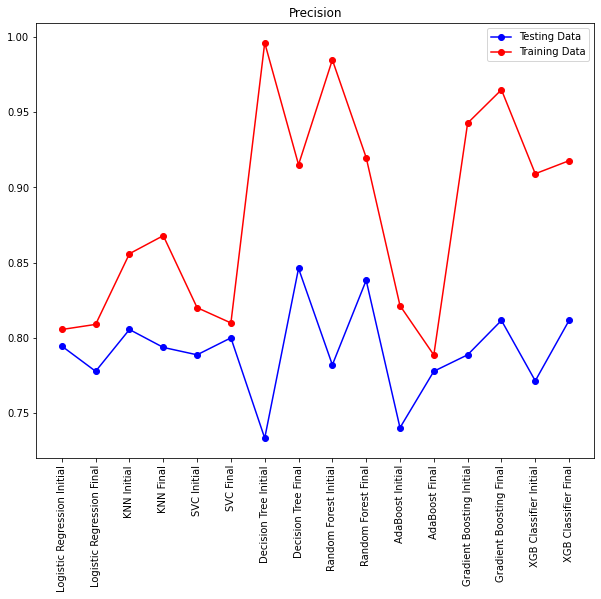

In [59]:
plot_metrics("Precision")

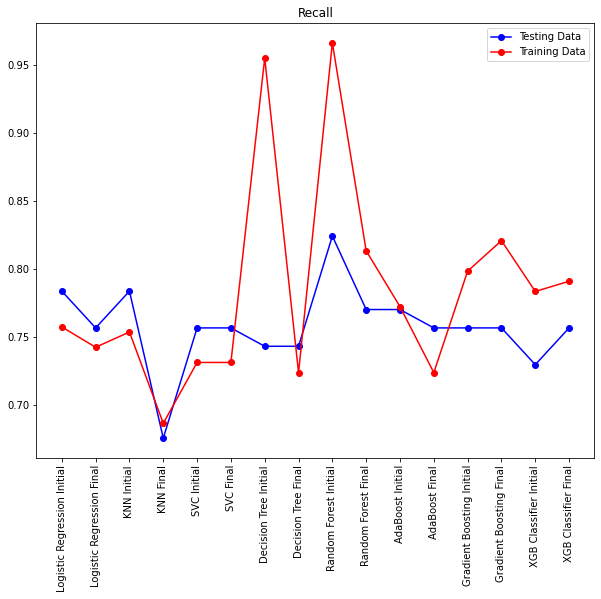

In [60]:
plot_metrics("Recall")

In [61]:
performance_.to_csv('data/performance_on_test_data.csv',index=False)

In [62]:
train_fitting.to_csv('data/performance_on_train_data.csv',index=False)

# Done

In [170]:
data_test = pd.read_csv("data/test_final.csv")

In [171]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Applying Standard Scaler to Age and Fare both while it was not really necessary to apply this in Fare , that was not that much speaded after the previous log transformation
X[['Age','Fare']] = scaler.fit_transform(X[['Age','Fare']])
data_test[['Age','Fare']] = scaler.transform(data_test[['Age','Fare']])

- As we have many models whose accuracy are almost same, hence making an ensemble model of those whose accracy is greater than 0.83 
those are KNN Initial, Decision Tree Final, Random Forest Final

In [172]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [173]:
knn = KNeighborsClassifier()
dtc = DecisionTreeClassifier(ccp_alpha= 0.0, class_weight= None, criterion= 'gini', max_depth= 7, min_samples_leaf= 1, min_samples_split= 10)
rfc = RandomForestClassifier(ccp_alpha= 0.001, class_weight= None, criterion= 'gini', max_depth=12, max_features= None, min_samples_leaf= 2, min_samples_split= 10, n_estimators= 70)

In [181]:
from sklearn.ensemble import VotingClassifier

In [182]:
vgc = VotingClassifier(estimators  =[ ('knn',knn), ('dtc', dtc), ('rfc',rfc) ], voting='hard', weights=[1,2,3] )

In [184]:
vgc.fit(X,y)

VotingClassifier(estimators=[('knn', KNeighborsClassifier()),
                             ('dtc',
                              DecisionTreeClassifier(max_depth=7,
                                                     min_samples_split=10)),
                             ('rfc',
                              RandomForestClassifier(ccp_alpha=0.001,
                                                     max_depth=12,
                                                     max_features=None,
                                                     min_samples_leaf=2,
                                                     min_samples_split=10,
                                                     n_estimators=70))],
                 weights=[1, 2, 3])

In [185]:
predictions = pd.DataFrame(vgc.predict(data_test), columns=['Survived'])

In [186]:
passenger_id = pd.read_csv("data/test.csv").PassengerId

In [187]:
pd.concat([passenger_id,pd.DataFrame(predictions)],axis=1).to_csv('data/submission.csv',index=False)